<a href="https://colab.research.google.com/github/Koks-creator/SpeechToText2/blob/main/SpeechToText_LibriSpeech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Connect to Google Drive

In [ ]:
!pip install jiwer

In [ ]:
from google.colab import drive
import os

In [ ]:
CHECKPOINT_PATH = "/content/drive/MyDrive/speech_recognition_checkpoints3/checkpoint_{epoch:02d}"

In [ ]:
drive.mount('/content/drive')
CHECKPOINT_DIR = os.path.dirname(CHECKPOINT_PATH)

Mounted at /content/drive


# 2. Download data

In [ ]:
!wget https://www.openslr.org/resources/12/train-clean-100.tar.gz
!tar -xzf train-clean-100.tar.gz

--2026-01-15 10:09:32--  https://www.openslr.org/resources/12/train-clean-100.tar.gz
Resolving www.openslr.org (www.openslr.org)... 136.243.171.4
Connecting to www.openslr.org (www.openslr.org)|136.243.171.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6387309499 (5.9G) [application/x-gzip]
Saving to: ‘train-clean-100.tar.gz’

train-clean-100.tar 100%[===================>]   5.95G  18.9MB/s    in 5m 27s  

2026-01-15 10:15:00 (18.6 MB/s) - ‘train-clean-100.tar.gz’ saved [6387309499/6387309499]



In [ ]:
import os
from glob import glob
import pandas as pd
from pathlib import Path
from typing import Tuple, List
import pickle
import csv
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.types.experimental import TensorLike
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer, cer
import soundfile as sf

In [ ]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.19.0
Num GPUs Available:  1


# 3. Config

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE # special constant that automatically adjusts the number of concurrent threads or processes to process data in the data pipeline
TRAIN_SIZE = .8
VAL_SIZE = .1
TEST_SIZE = .1
# The window length in samples.
FRAME_LENGTH = 256
# The number of samples to step.
FRAME_STEP = 160
# The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
FFT_LENGTH = 384
DATA_PATH = "/content/LibriSpeech/train-clean-100/"
LEARNING_RATE = 1e-4
BATCH_SIZE = 32
EPOCHS = 30
RNN_UNITS = 256
RNN_LAYERS = 4
MODEL_PATH = "speech_model3.h5"
CHAR2NUM_PATH = "char_to_num.pkl"
NUM2CHAR_PATH = "num_to_char.pkl"
LOAD_CHECKPOINT = True

In [ ]:
os.makedirs(CHECKPOINT_DIR, exist_ok=True) # create dir for trainig history and checkpoints

# 4. Prepare datasets

In [ ]:
def extract_name_transcription(txt_file: Path, ext: str = ".flac") -> tuple[list, list]:
    parent_path = os.path.split(txt_file)[0]

    file_paths = []
    transcriptions = []
    with open(txt_file) as f:
        for line in f.read().split("\n"):
            if line:
                splitted = line.split(" ")
                filename, transcirption = splitted[0], " ".join(splitted[1:]).lower()
                file_path = f"{parent_path}/{filename}{ext}"

                file_paths.append(file_path)
                transcriptions.append(transcirption)

    return file_paths, transcriptions


In [ ]:
#extract_name_transcription("/content/LibriSpeech/dev-clean/1272/135031/1272-135031.trans.txt")

In [ ]:
file_paths_all = []
transcriptions_all = []

In [ ]:
for sub_folder in os.listdir(DATA_PATH):
    for sub_sub_folder in os.listdir(f"{DATA_PATH}{sub_folder}"):
        text_file = glob(f"{DATA_PATH}{sub_folder}/{sub_sub_folder}/*.txt")[0]
        file_paths, transcriptions = extract_name_transcription(
            txt_file=text_file
        )

        file_paths_all.extend(file_paths)
        transcriptions_all.extend(transcriptions)


In [ ]:
file_paths_all[:100]

['/content/LibriSpeech/train-clean-100/3699/19402/3699-19402-0000.flac',
 '/content/LibriSpeech/train-clean-100/3699/19402/3699-19402-0001.flac',
 '/content/LibriSpeech/train-clean-100/3699/19402/3699-19402-0002.flac',
 '/content/LibriSpeech/train-clean-100/3699/19402/3699-19402-0003.flac',
 '/content/LibriSpeech/train-clean-100/3699/19402/3699-19402-0004.flac',
 '/content/LibriSpeech/train-clean-100/3699/19402/3699-19402-0005.flac',
 '/content/LibriSpeech/train-clean-100/3699/19402/3699-19402-0006.flac',
 '/content/LibriSpeech/train-clean-100/3699/19402/3699-19402-0007.flac',
 '/content/LibriSpeech/train-clean-100/3699/19402/3699-19402-0008.flac',
 '/content/LibriSpeech/train-clean-100/3699/19402/3699-19402-0009.flac',
 '/content/LibriSpeech/train-clean-100/3699/19402/3699-19402-0010.flac',
 '/content/LibriSpeech/train-clean-100/3699/19402/3699-19402-0011.flac',
 '/content/LibriSpeech/train-clean-100/3699/19402/3699-19402-0012.flac',
 '/content/LibriSpeech/train-clean-100/3699/19402/3

In [ ]:
transcriptions_all[:100]

['the rough riders at guasimas on the day the american troops landed on the coast of cuba the cubans informed general wheeler',
 'blocking the way to santiago',
 'nor even a collection of houses it is the meeting place of two trails which join at the apex of a v three miles from the seaport town of siboney and continue merged in a single trail to santiago',
 'general wheeler guided by the cubans reconnoitred this trail on the twenty third of june and with the position of the enemy fully explained to him returned to siboney and informed general young and colonel wood',
 'that on the following morning he would attack the spanish position',
 "and what he was to do when he found him that night no one slept for until two o'clock in the morning troops were still being disembarked in the surf and two ships of war had their searchlights turned on the landing place",
 'lay the camp of the rough riders and through it cuban officers were riding their half starved ponies and scattering the ashes o

In [ ]:
df = pd.DataFrame(
    {
        "FilePath": file_paths_all,
        "Transcirption": transcriptions_all
    }

)

In [ ]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# df = df.head(20000) # if u want to limit dataset

In [ ]:
df.head().iloc[0]["FilePath"]

'/content/LibriSpeech/train-clean-100/27/124992/27-124992-0019.flac'

In [ ]:
df.head().iloc[0]["Transcirption"]

'mesopotamia and syria sobal and libya'

In [ ]:
num_samples = len(df)
train_range = slice(0, int(TRAIN_SIZE * num_samples))
val_range = slice(int(train_range.stop), int(train_range.stop + (VAL_SIZE * num_samples)))
test_range = slice(val_range.stop, int(val_range.stop + (TEST_SIZE * num_samples)))

In [ ]:
df_train = df[train_range]
df_val = df[val_range]
df_test = df[test_range]

print(f"{len(df_train)=}")
print(f"{len(df_val)=}")
print(f"{len(df_test)=}")

len(df_train)=22831
len(df_val)=2853
len(df_test)=2853


In [ ]:
# if u wanna download some test data
# from google.colab import files
# xd = df_test["FilePath"].to_list()[:10]
# for x in xd:
#   files.download(x)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Mappings

# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]

# Characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")

# Integers to characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()}"
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_("'"), np.str_('?'), np.str_('!'), np.str_(' ')](size =31)


In [ ]:
def encode_single_sample(wav_file: str, label: str, frame_length: int = FRAME_LENGTH,
                         frame_step: int = FRAME_STEP,
                         fft_length: int = FFT_LENGTH
                         ) -> Tuple[EagerTensor, EagerTensor]:

    # Wrapper for soundfile
    def load_audio(path):
        audio, _ = sf.read(path.numpy().decode('utf-8'))
        return audio.astype('float32')

    audio = tf.py_function(
        load_audio,
        [wav_file],
        tf.float32
    )
    audio = tf.squeeze(audio)
    audio.set_shape([None])

    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, .5)

    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)

    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_num(label)

    return spectrogram, label

In [ ]:
PADDING_TOKEN = char_to_num.vocabulary_size()

**Define test, train, val datasets**

In [ ]:
"""
Problem: GPUs/TPUs operate on tensors with fixed dimensions. Without padding, it is impossible to assemble a batch.

That's why padded batch is important

`padded_batch` — length alignment in a batch

Tensors in a batch must have identical dimensions. Recordings and transcriptions have different lengths:
```
Sample 1: “hello”      → [8, 5, 12, 12, 15]         (5 characters)
Sample 2: “hi”         → [8, 9]                      (2 characters)
Sample 3: “hey there”  → [8, 5, 25, 0, 20, 8, 5, 18, 5] (9 characters)
```

`padded_batch` aligns to the longest in the batch:
```
Sample 1: [8, 5, 12, 12, 15, 31, 31, 31, 31]  # +4 padding
Sample 2: [8, 9, 31, 31, 31, 31, 31, 31, 31]  # +7 padding
Sample 3: [8, 5, 25,  0, 20,  8,  5, 18,  5]  # no padding
"""

# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["FilePath"]), list(df_train["Transcirption"]))
)
train_dataset = (
    train_dataset
    # .shuffle(buffer_size=len(df_train))
    .map(encode_single_sample, num_parallel_calls=AUTOTUNE)
    .padded_batch(
        BATCH_SIZE,  # sample num
        padded_shapes=([None, FFT_LENGTH // 2 + 1], [None]), # to what dimension - spectrogram (None - any length, FFT_LENGTH // 2 + 1 - static bins), label (None - any length)
        padding_values=(0.0, tf.constant(PADDING_TOKEN, dtype=tf.int64)) # pad value, 0.0 for spectrogram, PADDING_TOKEN for label
    )
    .prefetch(buffer_size=AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["FilePath"]), list(df_val["Transcirption"]))
)
validation_dataset = (
    validation_dataset
    # .shuffle(buffer_size=len(df_train))
    .map(encode_single_sample, num_parallel_calls=AUTOTUNE)
    .padded_batch(
        BATCH_SIZE,
        padded_shapes=([None, FFT_LENGTH // 2 + 1], [None]),
        padding_values=(0.0, tf.constant(PADDING_TOKEN, dtype=tf.int64))
    )
    .prefetch(buffer_size=AUTOTUNE)
)

# Define the test dataset
test_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_test["FilePath"]), list(df_test["Transcirption"]))
)
test_dataset = (
    test_dataset
    # .shuffle(buffer_size=len(df_train))
    .map(encode_single_sample, num_parallel_calls=AUTOTUNE)
    .padded_batch(
        BATCH_SIZE,
        padded_shapes=([None, FFT_LENGTH // 2 + 1], [None]),
        padding_values=(0.0, tf.constant(PADDING_TOKEN, dtype=tf.int64))
    )
    .prefetch(buffer_size=AUTOTUNE)
)

In [ ]:
df_train["FilePath"].to_list()[:100]

['/content/LibriSpeech/train-clean-100/27/124992/27-124992-0019.flac',
 '/content/LibriSpeech/train-clean-100/211/122442/211-122442-0001.flac',
 '/content/LibriSpeech/train-clean-100/2289/152253/2289-152253-0001.flac',
 '/content/LibriSpeech/train-clean-100/2836/5355/2836-5355-0025.flac',
 '/content/LibriSpeech/train-clean-100/8014/112602/8014-112602-0025.flac',
 '/content/LibriSpeech/train-clean-100/4195/186236/4195-186236-0020.flac',
 '/content/LibriSpeech/train-clean-100/4441/76250/4441-76250-0032.flac',
 '/content/LibriSpeech/train-clean-100/4680/16042/4680-16042-0032.flac',
 '/content/LibriSpeech/train-clean-100/302/123523/302-123523-0030.flac',
 '/content/LibriSpeech/train-clean-100/332/128985/332-128985-0025.flac',
 '/content/LibriSpeech/train-clean-100/4406/16882/4406-16882-0003.flac',
 '/content/LibriSpeech/train-clean-100/1578/6379/1578-6379-0042.flac',
 '/content/LibriSpeech/train-clean-100/4014/186175/4014-186175-0040.flac',
 '/content/LibriSpeech/train-clean-100/460/172359

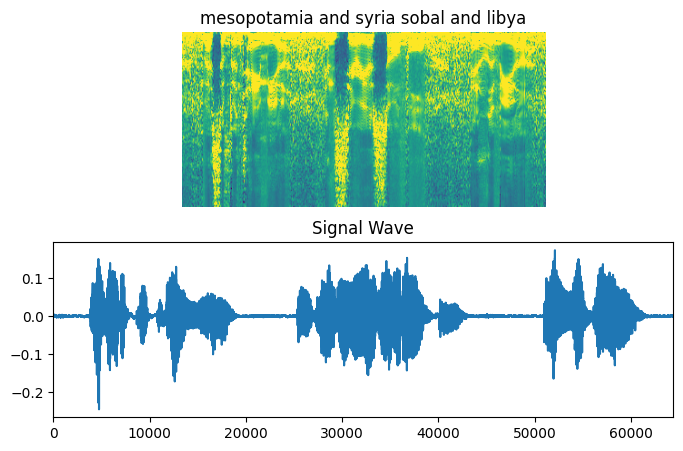

In [ ]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file_path = list(df_train["FilePath"])[0]
    audio, sample_rate = sf.read(file_path)
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(audio, rate=sample_rate))
plt.show()

# 5. Build model, add callbacks

##  CTC loss
CTC loss, or **Connectionist Temporal Classification Loss**, is a loss function used primarily in sequence recognition tasks where the output length is not specified. It is particularly useful in speech recognition, image-to-text transcription (OCR) and other sequence processing model

 - **How does CTC Loss work?** <br>
Independence of input and output length: In many cases, the length of the input sequence (e.g., the number of frames in an audio recording) differs from the length of the expected output sequence (e.g., the number of characters in a transcription). CTC is designed to handle this problem.

- **Inserting a “blank” symbol**: <br>
 CTC uses an additional blank symbol (meaning “no character”) to help deal with the situation when the model does not predict a new character in each input frame. Blank symbols allow the model to differentiate between adjacent characters and ignore redundant predictions.

- **Different matches (alignment)**: <br>
CTC calculates the probability of different possible matches between the input sequence and the output sequence. For example, for an input audio signal that corresponds to the output “HELLO,” the model can generate multiple combinations (e.g., “H_E_LL_O_” where “_” is a blank) that will be interpreted as correct transcriptions.

In sequential tasks like speech recognition, the length of the input (e.g., the number of audio frames) is variable, as is the length of the output (e.g., the number of words or characters in a transcription). CTCLoss is designed specifically to deal with this variability in length, allowing for different input to output matches and inserting blank symbols in the appropriate places

Read some more boyo here maybe:
 - https://voidful.medium.comunderstanding-ctc-loss-for-speech-recognition-a16a3ef4da92

 - https://medium.com/@akp83540/connectionist-temporal-classification-ctc-722bbb767e62

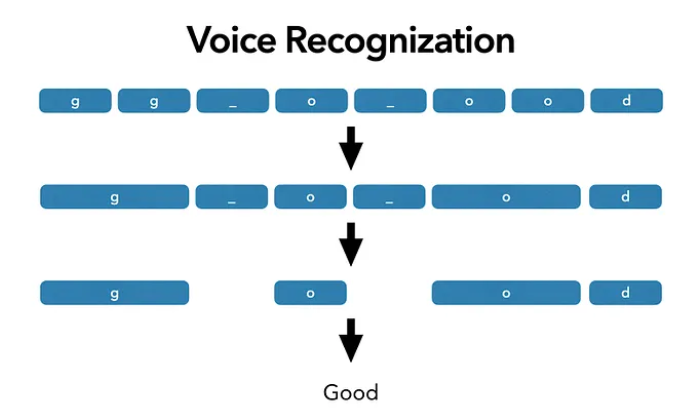

In [ ]:
# static label_length (assumes uniform length or padding=blank), default padding is 0, so is blank token
# def CTCLoss(y_true: TensorLike, y_pred: TensorLike) -> tf.Tensor:
#     # Compute the training-time loss value
#     batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
#     input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
#     label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

#     input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
#     label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

#     loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
#     return loss

# dynamic label_length (handles any padding token)
def CTCLoss(y_true: TensorLike, y_pred: TensorLike) -> tf.Tensor:
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")

    # Calculate the actual length of each label (without padding)
    mask = tf.not_equal(y_true, PADDING_TOKEN)
    label_length = tf.reduce_sum(tf.cast(mask, dtype="int64"), axis=1)

    # Set padding token to 0 (blank for CTC)
    y_true_clean = tf.where(
        tf.equal(y_true, PADDING_TOKEN), # if element is equal to PADDING_TOKEN
        tf.zeros_like(y_true), # if yes then insert 0 (blank token)
        y_true # if not, the leave as is
    )

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = tf.reshape(label_length, (-1, 1))

    loss = keras.backend.ctc_batch_cost(y_true_clean, y_pred, input_length, label_length)
    return loss

In [ ]:
def ctc_accuracy(y_true: TensorLike, y_pred: TensorLike) -> tf.Tensor:
    # Get batch size and max length for input lengths
    batch_size = tf.shape(y_pred)[0]
    max_length = tf.shape(y_pred)[1]
    input_lengths = tf.fill([batch_size], max_length)

    # Convert y_true to SparseTensor (ignoruj PADDING_TOKEN)
    y_true = tf.cast(y_true, tf.int64)
    indices = tf.where(tf.not_equal(y_true, PADDING_TOKEN))
    values = tf.gather_nd(y_true, indices)
    dense_shape = tf.cast(tf.shape(y_true), tf.int64)
    y_true_sparse = tf.SparseTensor(indices, values, dense_shape)

    # Decode the predictions
    decoded, _ = tf.nn.ctc_greedy_decoder(
        tf.transpose(y_pred, [1, 0, 2]),
        input_lengths,
        merge_repeated=True
    )

    # Cast decoded values to int64
    decoded_sparse = tf.cast(decoded[0], tf.int64)

    # Calculate accuracy using edit_distance
    accuracy = 1 - tf.reduce_mean(
        tf.edit_distance(decoded_sparse, y_true_sparse, normalize=True)
    )

    return accuracy

In [ ]:
def build_model(input_dim: int, output_dim: int, rnn_layers: int = 5, rnn_units: int = 128, learning_rate: float = 1e-4) -> keras.Model:
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input") # (None, None, 193), batch, time, frequency bins
    # Speech inputs vary in length depending on the length of the audio clip.
    # By setting the time dimension to None, the model can accept inputs of varying lengths during both training and inference.

    # Expand the dimension to use 2D CNN
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)

    for i, (filters, kernel, stride) in enumerate([
        (32, [11, 41], [2, 2]),
        (32, [11, 21], [1, 2]),
        (64, [11, 11], [1, 2])
    ]):
        x = layers.Conv2D(filters, kernel, stride, padding="same", use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

    # Reshape to sequence, frequencies and channels are flattened into a single dimension of features.
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

    for i in range(1, rnn_layers+1):
        recurrent = layers.LSTM(
            units=rnn_units,
            return_sequences=True,
            name=f"lstm_{i}"
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers: # apply a Dropout layer only between the RNN layers, because after we don't need it
          x = layers.Dropout(rate=.2)(x)

    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)  # after activation it's fine
    x = layers.Dropout(rate=.2)(x)

    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)

    model = keras.Model(input_spectrogram, output, name="DeepSpeech")

    steps_per_epoch = len(df_train) // BATCH_SIZE
    lr_schedule = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-3,  # start LR
        decay_steps=EPOCHS * steps_per_epoch,
        alpha=1e-5  # end LR
    )

    opt = keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(optimizer=opt, loss=CTCLoss, metrics=[ctc_accuracy])

    return model

In [ ]:
model = build_model(
    input_dim=FFT_LENGTH // 2 + 1,  # take only unique frequency bins, 2nd hald is the mirror (the same thing)
    output_dim=char_to_num.vocabulary_size(),
    rnn_layers=RNN_LAYERS,
    rnn_units=RNN_UNITS,
    learning_rate=LEARNING_RATE
)
model.summary()

Model: "DeepSpeech"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, None, 193)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expand_dim (Reshape)            │ (None, None, 193, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, None, 97, 32)   │        14,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, None, 97, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, None, 97, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, None, 49, 32)   │       236,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, None, 49, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, None, 49, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, None, 25, 64)   │       247,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, None, 25, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, None, 25, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, None, 1600)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, None, 512)      │     3,803,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, None, 512)      │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, None, 512)      │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, None, 512)      │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 512)      │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1_relu (ReLU)             │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 32)       │        16,416 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 9,306,240 (35.50 MB)

 Trainable params: 9,305,984 (35.50 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
def load_latest_checkpoint(checkpoint_dir: str = CHECKPOINT_DIR) -> bool:
    # Get all checkpoint files and sort them
    checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_')])

    if checkpoints:
        latest_checkpoint = os.path.join(checkpoint_dir, checkpoints[-1])
        print(f"Loading checkpoint: {latest_checkpoint}")
        model.load_weights(latest_checkpoint)
        return True
    return False

**Load checkpoint**

In [ ]:
if LOAD_CHECKPOINT:
    load_latest_checkpoint()

Loading checkpoint: /content/drive/MyDrive/speech_recognition_checkpoints3/checkpoint_15.keras


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 75 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


**CSV logger**

In [ ]:
class CustomCSVLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_path):
        super().__init__()
        self.log_path = log_path
        self.epoch = 0

    def on_train_begin(self, logs = None) -> None:
        if os.path.exists(self.log_path):
            self.mode = "a"
            self.header = False
        else:
            self.mode = "w"
            self.header = True

        self.csvfile = open(self.log_path, self.mode, newline='')
        self.writer = csv.writer(self.csvfile)

        if self.header:
            self.writer.writerow(["epoch", "loss", "val_loss", "ctc_accuracy", "val_ctc_accuracy"])
            self.csvfile.flush()
        self.csvfile.close()

    def on_epoch_end(self, epoch: int, logs = None) -> None:
        self.csvfile = open(self.log_path, "a", newline='')
        self.writer = csv.writer(self.csvfile)
        logs = logs or {}

        row = [
            self.epoch,
            logs.get("loss", "N/A"),
            logs.get("val_loss", "N/A"),
            logs.get("ctc_accuracy", "N/A"),
            logs.get("val_ctc_accuracy", "N/A")
        ]
        self.writer.writerow(row)
        self.csvfile.flush()
        self.epoch += 1
        self.csvfile.close()

    def on_train_end(self, logs=None) -> None:
        self.csvfile.close()

# 6. Training

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=CHECKPOINT_PATH + ".keras",
        save_weights_only=False,
        save_best_only=True,
        monitor="val_loss",
        verbose=1
    ),
    CustomCSVLogger(fr"{CHECKPOINT_DIR}/training_log.csv")
]

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    initial_epoch=0,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 17/30
714/714 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - ctc_accuracy: 0.9291 - loss: 40.7619
Epoch 17: val_loss improved from inf to 45.65533, saving model to /content/drive/MyDrive/speech_recognition_checkpoints3/checkpoint_17.keras
714/714 ━━━━━━━━━━━━━━━━━━━━ 5150s 7s/step - ctc_accuracy: 0.9291 - loss: 40.7610 - val_ctc_accuracy: 0.9250 - val_loss: 45.6553
Epoch 18/30
714/714 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - ctc_accuracy: 0.9339 - loss: 37.7814
Epoch 18: val_loss did not improve from 45.65533
714/714 ━━━━━━━━━━━━━━━━━━━━ 2101s 3s/step - ctc_accuracy: 0.9340 - loss: 37.7806 - val_ctc_accuracy: 0.9259 - val_loss: 45.8820
Epoch 19/30
714/714 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - ctc_accuracy: 0.9385 - loss: 34.9246
Epoch 19: val_loss improved from 45.65533 to 45.46615, saving model to /content/drive/MyDrive/speech_recognition_checkpoints3/checkpoint_19.keras
714/714 ━━━━━━━━━━━━━━━━━━━━ 2054s 3s/step - ctc_accuracy: 0.9385 - loss: 34.9242 - val_ctc_accuracy: 0.9264 - val_loss: 45.4662
Epoc

KeyboardInterrupt: 

# 7. Test model

In [ ]:
def decode_batch_predictions(pred) -> List[str]:
    input_len = np.ones(pred.shape[0]) * pred.shape[1]

    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]

    output_text = []
    for result in results:
        # concatenates the characters into a single string in utf-8
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

In [ ]:
predictions = []
targets = []
for batch in test_dataset.take(2):
    X, y = batch

    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)

wer_score = wer(targets, predictions)
cer_score = cer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print(f"Character Error Rate: {cer_score:.4f}")
print("-" * 100)
for i in range(len(predictions)):
    print(f"Target        : {targets[i]}")
    print(f"Prediction    : {predictions[i]}")
    print("-" * 100)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2269
Character Error Rate: 0.0699
----------------------------------------------------------------------------------------------------
Target        : said carling icily you refuse absolutely jimmie dale's voice had a lingering wistful note in it i refuse said carling bluntly i won't have anything to do with it
Prediction    : sid carlig ecely you refuse absilutely jimih dales voicse had at lingering visful not in it i refuse said carling glantly i want have anything to do with it
----------------------------------------------------------------------------------------------------
Target        : what's the matter with an old man makeup and the front door just this friend murphy on watch hauls out his little paper and on the chance of its being me slaps the wrist of anybody who appears on those ste

# 8. Save artifacts

In [ ]:
model.save(MODEL_PATH)

with open(CHAR2NUM_PATH, "wb") as c2n_file:
    pickle.dump(char_to_num, c2n_file)

with open(NUM2CHAR_PATH, "wb") as n2c_file:
    pickle.dump(num_to_char, n2c_file)